## Import Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn import metrics

In [3]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder
import pickle

In [4]:
from lib_model_cluster import showTestCluster, showTestKMean

In [5]:
data_original = pd.read_csv("data_preprocessing/data_final.csv", index_col=0)
data_original.shape

(707, 11)

## Check Outlier

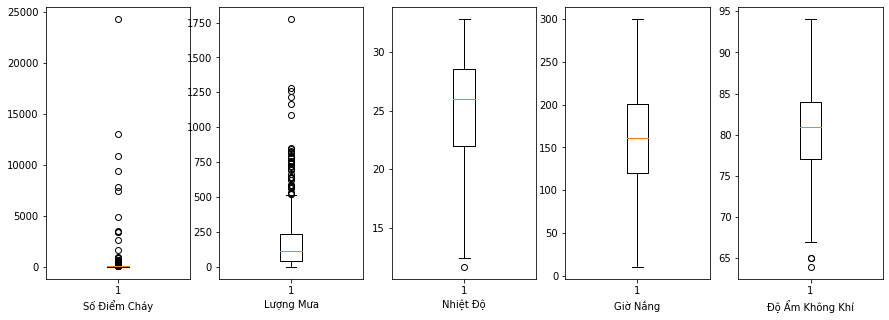

In [6]:
plt.figure(figsize=(15,5))
# ----------------
plt.subplot(1,5,1)
plt.boxplot(
    data_original.So_Diem_Chay
)
plt.xlabel('Số Điểm Cháy')
# ----------------
plt.subplot(1,5,2)
plt.boxplot(
    data_original.Rainfull
)
plt.xlabel('Lượng Mưa')
# ----------------
plt.subplot(1,5,3)
plt.boxplot(
    data_original.Air_Temperature
)
plt.xlabel('Nhiệt Độ')
# ----------------
plt.subplot(1,5,4)
plt.boxplot(
    data_original.Sunshine
)
plt.xlabel('Giờ Nắng')
# ----------------
plt.subplot(1,5,5)
plt.boxplot(
    data_original.Air_Humidity
)
plt.xlabel('Độ Ẩm Không Khí')
# ----------------
plt.show()

Cả 5 feature số điểm cháy, lượng mưa, nhiệt độ, độ ẫm không khí đều có outlier, vì vậy sẽ dùng RobustScaler để scale dữ liệu.

## Function

In [7]:
def checkComponentWSSE(data):
    scale = RobustScaler()
    data_scale = scale.fit_transform(data)
    length_columns = data.shape[1]
    dict_df = {}
    for col in range(0, length_columns):
        dict_df[col] = data_scale[: , col]
    df = pd.DataFrame(dict_df)
    for number in range(0, length_columns):
        columns = list(df.columns)
        col = columns.pop(number)
        df_sub = df[columns]
        showTestCluster(df_sub, 10, 'Remove: ' + data.columns[col])

In [8]:
def buildModel(data, k):
    preprocess = make_column_transformer(
        (RobustScaler(), data.columns),
    )
    pipeline = make_pipeline(
        preprocess,
        KMeans(n_clusters=k, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    )
    return pipeline.fit(data)

In [9]:
def showCorr(title, data_original):
    tuple_name = set(
        data_original.Name  
    )
    columns = [
        'Ten Tinh', 
        'So_Diem_Chay VS Sunshine', 
        'So_Diem_Chay VS Air_Humidity', 
        'So_Diem_Chay VS Air_Temperature', 
        'So_Diem_Chay VS Rainfull', 
    ]
    df_corr = pd.DataFrame(columns=columns)
    for name in tuple_name:
        df = data_original[data_original.Name == name]
        new_row = pd.Series(
            data = {
                columns[0]: name,
                columns[1]: df.So_Diem_Chay.corr(df.Sunshine),
                columns[2]: df.So_Diem_Chay.corr(df.Air_Humidity),
                columns[3]: df.So_Diem_Chay.corr(df.Air_Temperature),
                columns[4]: df.So_Diem_Chay.corr(df.Rainfull)
            }
        )
        df_corr = df_corr.append(new_row, ignore_index=True)
    df_corr_show = df_corr.set_index('Ten Tinh')
    plt.figure(figsize=(10, 2))
    sb.heatmap(
        df_corr_show.T,
        annot=True,
        vmax=1,
        vmin=-1,
        fmt='0.1f',
        cmap='coolwarm'
    )
    plt.title(title + ': Mối quan hệ giữa các chỉ số thời tiết với số Điểm cháy qua các tỉnh', fontweight='bold', fontsize=14)
    plt.show()

## Build Model 2017

In [10]:
df_group = data_original[data_original.Nam == 2017].groupby(['Name', 'Ma_Tinh']).mean().reset_index()
data_2017 = df_group[['So_Diem_Chay','Sunshine','Air_Humidity','Air_Temperature','Rainfull']]
data_2017.head()

,So_Diem_Chay,Sunshine,Air_Humidity,Air_Temperature,Rainfull
0,19.500000,160.290000,81.800000,28.030000,210.510000
1,48.000000,175.200000,86.888889,26.577778,364.744444
2,25.375000,103.162500,76.000000,26.737500,205.512500
3,105.666667,141.591667,84.333333,19.691667,264.925000
4,6.142857,121.242857,82.571429,26.600000,289.071429


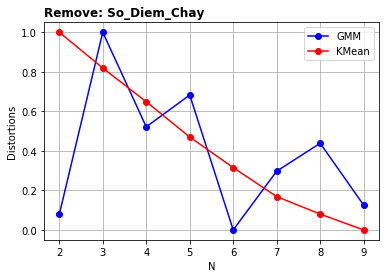

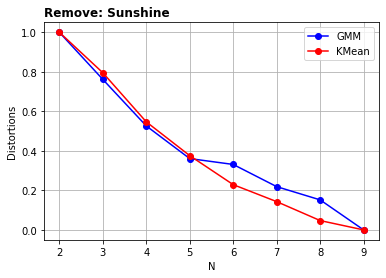

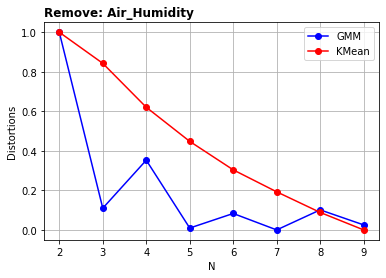

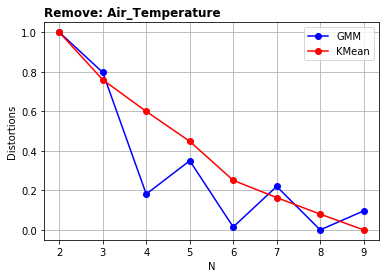

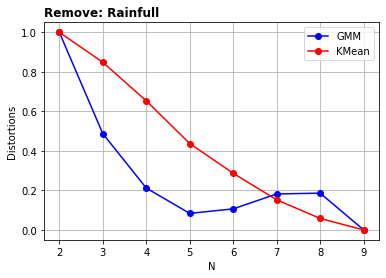

In [11]:
checkComponentWSSE(data_2017)

Từ những biểu đồ trên ta có thể thấy : 
<blockquote>
    - Model K-Mean chạy ỗn định hơn GMM trong trường hợp này. <br>
</blockquote>

In [12]:
model_2017 = buildModel(data_2017, 3)
data_2017 = data_2017.assign(
    Ma_Tinh = df_group.Ma_Tinh,
    Ten_Tinh = df_group.Name,
    Group = model_2017.predict(data_2017)
)
data_2017

,So_Diem_Chay,Sunshine,Air_Humidity,Air_Temperature,Rainfull,Ma_Tinh,Ten_Tinh,Group
0,19.500000,160.290000,81.800000,28.030000,210.510000,96.0,Cà Mau,1
1,48.000000,175.200000,86.888889,26.577778,364.744444,46.0,Huế,2
2,25.375000,103.162500,76.000000,26.737500,205.512500,1.0,Hà Nội,1
3,105.666667,141.591667,84.333333,19.691667,264.925000,12.0,Lai Châu,0
4,6.142857,121.242857,82.571429,26.600000,289.071429,36.0,Nam Định,1
5,153.583333,160.541667,78.750000,21.658333,115.166667,14.0,Sơn La,0
6,40.250000,120.691667,81.500000,24.175000,197.725000,8.0,Tuyên Quang,1
7,14.714286,129.857143,80.714286,26.442857,278.657143,84.0,Vinh,1
8,26.818182,215.518182,78.727273,28.100000,155.390909,77.0,Vũng Tàu,1
9,9.857143,177.785714,80.857143,27.328571,280.300000,48.0,Đà Nẵng,1


In [13]:
display(
    data_2017[data_2017.Group == 0],
    data_2017[data_2017.Group == 1],
    data_2017[data_2017.Group == 2]
)

,So_Diem_Chay,Sunshine,Air_Humidity,Air_Temperature,Rainfull,Ma_Tinh,Ten_Tinh,Group
3,105.666667,141.591667,84.333333,19.691667,264.925000,12.0,Lai Châu,0
5,153.583333,160.541667,78.750000,21.658333,115.166667,14.0,Sơn La,0


,So_Diem_Chay,Sunshine,Air_Humidity,Air_Temperature,Rainfull,Ma_Tinh,Ten_Tinh,Group
0,19.500000,160.290000,81.800000,28.030000,210.510000,96.0,Cà Mau,1
2,25.375000,103.162500,76.000000,26.737500,205.512500,1.0,Hà Nội,1
4,6.142857,121.242857,82.571429,26.600000,289.071429,36.0,Nam Định,1
6,40.250000,120.691667,81.500000,24.175000,197.725000,8.0,Tuyên Quang,1
7,14.714286,129.857143,80.714286,26.442857,278.657143,84.0,Vinh,1
8,26.818182,215.518182,78.727273,28.100000,155.390909,77.0,Vũng Tàu,1
9,9.857143,177.785714,80.857143,27.328571,280.300000,48.0,Đà Nẵng,1


,So_Diem_Chay,Sunshine,Air_Humidity,Air_Temperature,Rainfull,Ma_Tinh,Ten_Tinh,Group
1,48.0,175.2,86.888889,26.577778,364.744444,46.0,Huế,2


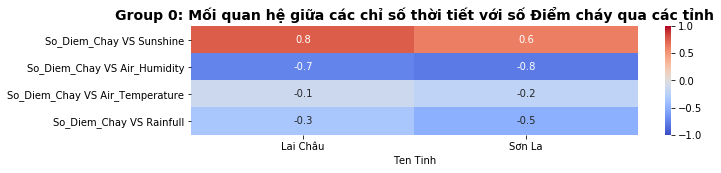

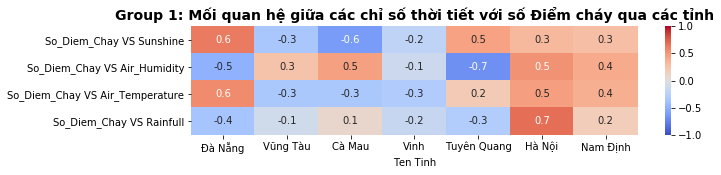

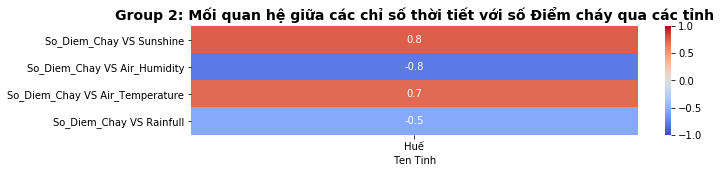

None

None

None

In [14]:
dict_group = {}
for index in range(0, data_2017.shape[0]):
    key = data_2017[['Ma_Tinh', 'Group']].iloc[index, 0]
    value = data_2017[['Ma_Tinh', 'Group']].iloc[index, 1]
    dict_group[key] = value
data_show = data_original[
    data_original.Nam == 2017
].assign(
    Group = data_original.Ma_Tinh.map(lambda x: dict_group[x])
)
# ----------------
data_show.to_csv('data_model/data_corr_2017.csv')
# ----------------
display(
    showCorr('Group 0', data_show[data_show.Group == 0]),
    showCorr('Group 1', data_show[data_show.Group == 1]),
    showCorr('Group 2', data_show[data_show.Group == 2])
)

## Build Model 2018

In [15]:
df_group = data_original[data_original.Nam == 2018].groupby(['Name', 'Ma_Tinh']).mean().reset_index()
data_2018 = df_group[['So_Diem_Chay','Sunshine','Air_Humidity','Air_Temperature','Rainfull']]
data_2018.head()

,So_Diem_Chay,Sunshine,Air_Humidity,Air_Temperature,Rainfull
0,48.500000,163.641667,80.666667,27.916667,167.316667
1,149.916667,162.808333,86.750000,25.116667,209.775000
2,35.000000,106.183333,75.250000,25.100000,141.241667
3,762.416667,153.750000,85.000000,20.025000,241.258333
4,17.500000,119.308333,82.500000,24.450000,150.008333


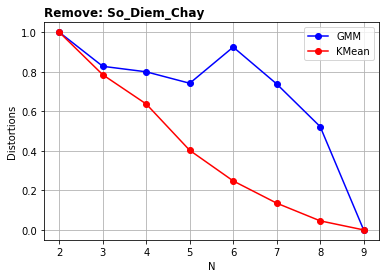

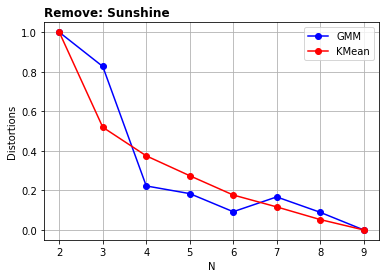

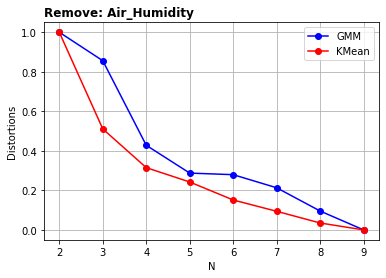

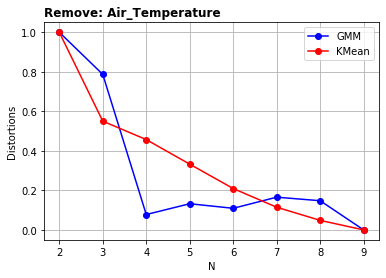

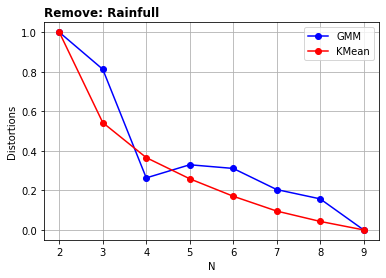

In [16]:
checkComponentWSSE(data_2018)

Từ những biểu đồ trên ta có thể thấy : 
<blockquote>
    - Model K-Mean chạy ỗn định hơn GMM trong trường hợp này. <br>
    - Feature 'Số Điểm cháy' có ảnh hưởng mạnh đến việc phân nhóm. <br>
    - Những feature còn lại sẽ có giá trị phân tích. <br>
    - Sẽ có 3 nhóm tối ưu trong trường hợp này.
</blockquote>

In [17]:
model_2018 = buildModel(data_2018, 3)
data_2018 = data_2018.assign(
    Ma_Tinh = df_group.Ma_Tinh,
    Ten_Tinh = df_group.Name,
    Group = model_2018.predict(data_2018)
)
data_2018

,So_Diem_Chay,Sunshine,Air_Humidity,Air_Temperature,Rainfull,Ma_Tinh,Ten_Tinh,Group
0,48.500000,163.641667,80.666667,27.916667,167.316667,96.0,Cà Mau,1
1,149.916667,162.808333,86.750000,25.116667,209.775000,46.0,Huế,1
2,35.000000,106.183333,75.250000,25.100000,141.241667,1.0,Hà Nội,1
3,762.416667,153.750000,85.000000,20.025000,241.258333,12.0,Lai Châu,0
4,17.500000,119.308333,82.500000,24.450000,150.008333,36.0,Nam Định,1
5,1720.666667,168.375000,79.083333,21.641667,128.300000,14.0,Sơn La,2
6,137.416667,124.791667,81.083333,24.375000,127.850000,8.0,Tuyên Quang,1
7,48.583333,138.766667,82.750000,24.916667,159.891667,84.0,Vinh,1
8,120.727273,213.927273,78.454545,28.090909,142.845455,77.0,Vũng Tàu,1
9,38.666667,171.933333,79.666667,26.516667,211.591667,48.0,Đà Nẵng,1


In [18]:
display(
    data_2018[data_2018.Group == 0],
    data_2018[data_2018.Group == 1],
    data_2018[data_2018.Group == 2]
)

,So_Diem_Chay,Sunshine,Air_Humidity,Air_Temperature,Rainfull,Ma_Tinh,Ten_Tinh,Group
3,762.416667,153.75,85.0,20.025,241.258333,12.0,Lai Châu,0


,So_Diem_Chay,Sunshine,Air_Humidity,Air_Temperature,Rainfull,Ma_Tinh,Ten_Tinh,Group
0,48.500000,163.641667,80.666667,27.916667,167.316667,96.0,Cà Mau,1
1,149.916667,162.808333,86.750000,25.116667,209.775000,46.0,Huế,1
2,35.000000,106.183333,75.250000,25.100000,141.241667,1.0,Hà Nội,1
4,17.500000,119.308333,82.500000,24.450000,150.008333,36.0,Nam Định,1
6,137.416667,124.791667,81.083333,24.375000,127.850000,8.0,Tuyên Quang,1
7,48.583333,138.766667,82.750000,24.916667,159.891667,84.0,Vinh,1
8,120.727273,213.927273,78.454545,28.090909,142.845455,77.0,Vũng Tàu,1
9,38.666667,171.933333,79.666667,26.516667,211.591667,48.0,Đà Nẵng,1


,So_Diem_Chay,Sunshine,Air_Humidity,Air_Temperature,Rainfull,Ma_Tinh,Ten_Tinh,Group
5,1720.666667,168.375,79.083333,21.641667,128.3,14.0,Sơn La,2


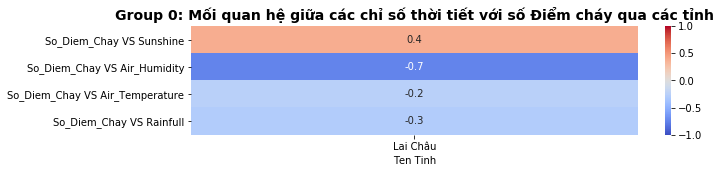

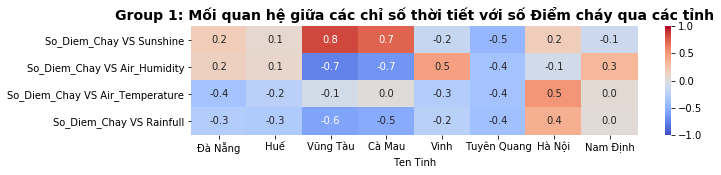

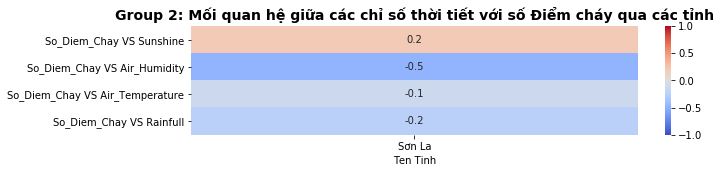

None

None

None

In [19]:
dict_group = {}
for index in range(0, data_2018.shape[0]):
    key = data_2018[['Ma_Tinh', 'Group']].iloc[index, 0]
    value = data_2018[['Ma_Tinh', 'Group']].iloc[index, 1]
    dict_group[key] = value
data_show = data_original[
    data_original.Nam == 2018
].assign(
    Group = data_original.Ma_Tinh.map(lambda x: dict_group[x])
)
# ----------------
data_show.to_csv('data_model/data_corr_2018.csv')
# ----------------
display(
    showCorr('Group 0', data_show[data_show.Group == 0]),
    showCorr('Group 1', data_show[data_show.Group == 1]),
    showCorr('Group 2', data_show[data_show.Group == 2])
)

## Build Model 2019

In [20]:
df_group = data_original[data_original.Nam == 2019].groupby(['Name', 'Ma_Tinh']).mean().reset_index()
data_2019 = df_group[['So_Diem_Chay','Sunshine','Air_Humidity','Air_Temperature','Rainfull']]
data_2019.head()

,So_Diem_Chay,Sunshine,Air_Humidity,Air_Temperature,Rainfull
0,141.0,175.010000,80.900000,28.210000,202.070000
1,205.5,182.500000,84.916667,26.358333,165.383333
2,17.0,110.416667,75.333333,25.908333,109.283333
3,1890.5,182.533333,82.083333,20.916667,211.875000
4,7.8,136.580000,82.200000,25.980000,109.730000


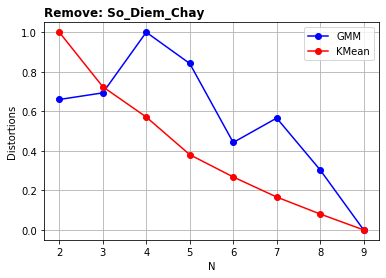

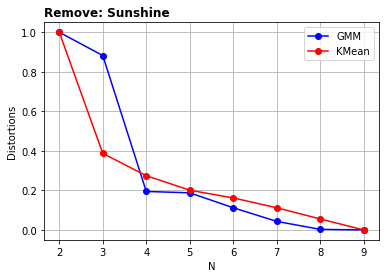

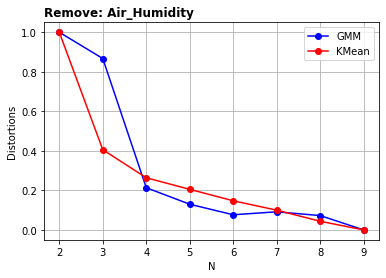

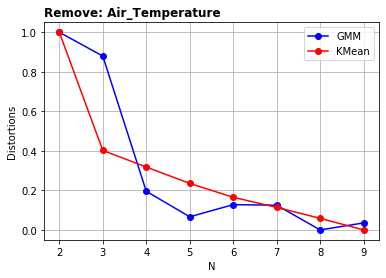

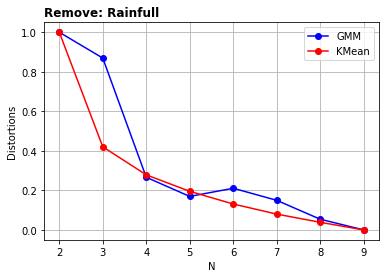

In [21]:
checkComponentWSSE(data_2019)

Từ những biểu đồ trên ta có thể thấy : 
<blockquote>
    - Model K-Mean chạy ỗn định hơn GMM trong trường hợp này. <br>
    - Feature 'Số Điểm cháy' có ảnh hưởng mạnh đến việc phân nhóm. <br>
    - Những feature còn lại sẽ có giá trị phân tích. <br>
    - Sẽ có 3 nhóm tối ưu trong trường hợp này.
</blockquote>

In [22]:
model_2019 = buildModel(data_2019, 3)
data_2019 = data_2019.assign(
    Ma_Tinh = df_group.Ma_Tinh,
    Ten_Tinh = df_group.Name,
    Group = model_2019.predict(data_2019)
)
data_2019

,So_Diem_Chay,Sunshine,Air_Humidity,Air_Temperature,Rainfull,Ma_Tinh,Ten_Tinh,Group
0,141.000000,175.010000,80.900000,28.210000,202.070000,96.0,Cà Mau,1
1,205.500000,182.500000,84.916667,26.358333,165.383333,46.0,Huế,1
2,17.000000,110.416667,75.333333,25.908333,109.283333,1.0,Hà Nội,1
3,1890.500000,182.533333,82.083333,20.916667,211.875000,12.0,Lai Châu,0
4,7.800000,136.580000,82.200000,25.980000,109.730000,36.0,Nam Định,1
5,3558.500000,199.166667,77.000000,22.733333,84.608333,14.0,Sơn La,2
6,162.083333,131.483333,81.916667,24.983333,121.300000,8.0,Tuyên Quang,1
7,79.333333,149.266667,82.444444,25.722222,192.800000,84.0,Vinh,1
8,98.222222,225.055556,77.222222,28.566667,118.655556,77.0,Vũng Tàu,1
9,40.500000,198.240000,77.600000,27.630000,201.980000,48.0,Đà Nẵng,1


In [23]:
display(
    data_2019[data_2019.Group == 0],
    data_2019[data_2019.Group == 1],
    data_2019[data_2019.Group == 2]
)

,So_Diem_Chay,Sunshine,Air_Humidity,Air_Temperature,Rainfull,Ma_Tinh,Ten_Tinh,Group
3,1890.5,182.533333,82.083333,20.916667,211.875,12.0,Lai Châu,0


,So_Diem_Chay,Sunshine,Air_Humidity,Air_Temperature,Rainfull,Ma_Tinh,Ten_Tinh,Group
0,141.000000,175.010000,80.900000,28.210000,202.070000,96.0,Cà Mau,1
1,205.500000,182.500000,84.916667,26.358333,165.383333,46.0,Huế,1
2,17.000000,110.416667,75.333333,25.908333,109.283333,1.0,Hà Nội,1
4,7.800000,136.580000,82.200000,25.980000,109.730000,36.0,Nam Định,1
6,162.083333,131.483333,81.916667,24.983333,121.300000,8.0,Tuyên Quang,1
7,79.333333,149.266667,82.444444,25.722222,192.800000,84.0,Vinh,1
8,98.222222,225.055556,77.222222,28.566667,118.655556,77.0,Vũng Tàu,1
9,40.500000,198.240000,77.600000,27.630000,201.980000,48.0,Đà Nẵng,1


,So_Diem_Chay,Sunshine,Air_Humidity,Air_Temperature,Rainfull,Ma_Tinh,Ten_Tinh,Group
5,3558.5,199.166667,77.0,22.733333,84.608333,14.0,Sơn La,2


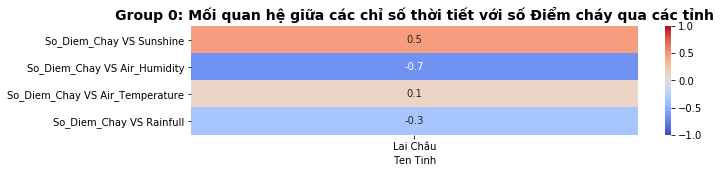

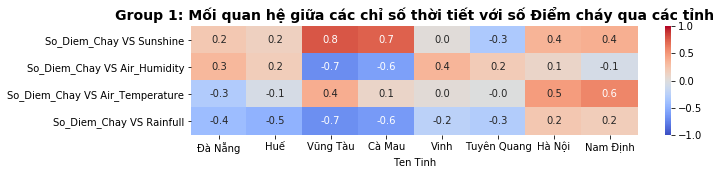

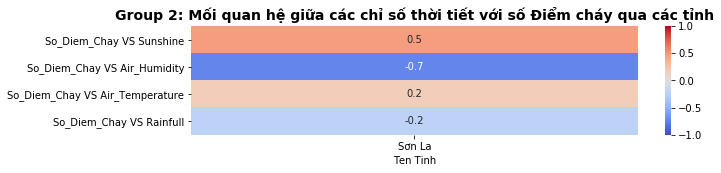

None

None

None

In [24]:
dict_group = {}
for index in range(0, data_2019.shape[0]):
    key = data_2019[['Ma_Tinh', 'Group']].iloc[index, 0]
    value = data_2019[['Ma_Tinh', 'Group']].iloc[index, 1]
    dict_group[key] = value
data_show = data_original[
    data_original.Nam == 2019
].assign(
    Group = data_original.Ma_Tinh.map(lambda x: dict_group[x])
)
# ----------------
data_show.to_csv('data_model/data_corr_2019.csv')
# ----------------
display(
    showCorr('Group 0', data_show[data_show.Group == 0]),
    showCorr('Group 1', data_show[data_show.Group == 1]),
    showCorr('Group 2', data_show[data_show.Group == 2])
)

## Save Model Cluster

In [25]:
filename = 'save_model/model_cluster_2017.sav'
pickle.dump(model_2017, open(filename, 'wb'))
#----------
loaded_model_2017 = pickle.load(open(filename, 'rb'))
#----------
print(
    'Group',
    loaded_model_2017.predict(
        data_2017.iloc[1, [0,1,2,3,4]].to_frame().T
    )[0]
)

Group 2


In [26]:
filename = 'save_model/model_cluster_2018.sav'
pickle.dump(model_2018, open(filename, 'wb'))
#----------
loaded_model_2018 = pickle.load(open(filename, 'rb'))
#----------
print(
    'Group',
    loaded_model_2018.predict(
        data_2018.iloc[1, [0,1,2,3,4]].to_frame().T
    )[0]
)

Group 1


In [27]:
filename = 'save_model/model_cluster_2019.sav'
pickle.dump(model_2019, open(filename, 'wb'))
#----------
loaded_model_2019 = pickle.load(open(filename, 'rb'))
#----------
print(
    'Group',
    loaded_model_2019.predict(
        data_2019.iloc[1, [0,1,2,3,4]].to_frame().T
    )[0]
)

Group 1
